In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp drive/MyDrive/data_for_env.csv.zip data_for_env.csv.zip

In [3]:
!unzip data_for_env.csv.zip

Archive:  data_for_env.csv.zip
  inflating: data_for_env.csv        
  inflating: __MACOSX/._data_for_env.csv  


In [82]:
############## ENV IMPORTS ##############
import random
import pandas as pd
############## GYM IMPORTS ##############
import gym
from gym.utils import seeding
from gym import error, spaces, utils
################ SETTINGS ################
DATA_PATH = 'data_for_env.csv'
LDG = 1
DEFAULT_MONTH_MIN = 3
############ DISABLE WARNINGS ############
import warnings

warnings.filterwarnings('ignore')
##########################################


class ScoringBasicEnv(gym.Env):
    """Среда, имитирующая работу банка с заданной отсечкой по score.
    Разработана с использованием фреймворка OpenAI Gym
    Variables:
        * env_mode [string] Режим отсечения, с которым работает среда
            'score' - score >= action
            'pd' - default_probability <= action
        * env_reward [string] Режим вознаграждения, с которым работает среда
            'score' - score >= action
            'pd' - default_probability <= action
        * data [pd.DataFrame] Отскоренные заявки клиентов
        * minYear [int] Год начала симуляции
        * minMonth [int] Месяц начала симуляции
        * maxYear [int] Год окончания симуляции
        * maxYear [int] Месяц начала симуляции
        * currYear [int] Текущий год
        * currMonth [int] Текущий месяц
        * state_hist [list(float)] История acceptance rate для симуляции
        * action_hist [list(float)] История действий агента в симуляции
        * reward_hist [list(float)] История вознаграждений агента в симуляции
        * reward_horizon [list(float)] Горизонт отложенных вознаграждений агента
    Methods:
        * step(self, action)
        * reset(self)
        * render(self, mode='human')
        * close(self)
    """

    metadata = {'render.modes': ['human']}

    def __init__(self, mode='score', reward='delayed', maxYear=None, maxMonth=None):
        """Стандартная инициализация среды
        Args:
            mode:
                [string] 'score' or 'pd'
                The type of action threshold
            reward:
                [string] 'immediate' or 'delayed'
                The type of return policy
            maxYear:
                [optional, int]
            maxMonth:
                [optional, int]
        Returns:
            None
        """

        # mode must be 'score' or 'pd'
        self.env_mode = mode
        # mode must be 'immediate' or 'delayed'
        self.env_reward = reward

        self.data = pd.read_csv(DATA_PATH)
        self.data.issue_d = pd.to_datetime(self.data.issue_d)
        self.data.term = self.data.term.replace({1: 36, 2: 60})
        self.data['tmp_year'] = self.data.issue_d.dt.year
        self.data['tmp_month'] = self.data.issue_d.dt.month
        self.data['interest_val'] = self.data.funded_amnt / (
            self.data.int_rate + self.data.int_rate /
            (((1 + self.data.int_rate)**self.data.term) - 1) * self.data.term)

        self.minYear = self.data.tmp_year.min()
        self.minMonth = self.data[self.data.tmp_year ==
                                  self.minYear].tmp_month.min()
        if maxYear is None:
            self.maxYear = self.data.tmp_year.max()
        else:
            self.maxYear = maxYear
        if maxMonth is None:
            self.maxMonth = self.data[self.data.tmp_year == self.maxYear].tmp_month.max()
        else:
            self.maxMonth = maxMonth

        self.currYear = None
        self.currMonth = None
        self.state_hist = None
        self.action_hist = None
        self.reward_hist = None
        self.reward_horizon = None

    def step(self, action):
        """Осуществляет один шаг среды
        Args:
            action:
                [float] Threshold value
        Returns:
            observation:
                [float] acceptance rate за неделю
            reward:
                [float] значение reward
            is_done:
                [bool] флаг того, что цикл закончился
            metadata:
                [dict] дополнительные метаданные; по-умолчанию - {}
        """

        if self.currYear <= self.maxYear or (self.currYear == self.maxYear and self.currMonth <= self.maxMonth):
            print(f'making step: {self.currYear}.{self.currMonth}')
            df_tmp = self.data[(self.data.tmp_year == self.currYear)
                               & (self.data.tmp_month == self.currMonth)]

            if self.env_mode == 'score':
                df_tmp['accepted'] = df_tmp.score_cat.apply(
                    lambda x: 1 if x >= action else 0)
            elif self.env_mode == 'pd':
                df_tmp['accepted'] = df_tmp.predict_cat.apply(
                    lambda x: 1 if x <= action else 0)

            immediate = 0

            for _, row in df_tmp[df_tmp.accepted == 1].iterrows():
                if row.target == 1:
                    # default
                    if self.env_reward == 'immediate':
                        immediate -= row.funded_amnt * LDG
                    else:
                        self.reward_horizon[random.randint(
                            DEFAULT_MONTH_MIN, row.term)] -= row.funded_amnt * LDG
                elif row.target == 0:
                    # success
                    if self.env_reward == 'immediate':
                        immediate += row.interest_val
                    else:
                        self.reward_horizon[row.term] += row.interest_val

            new_state = df_tmp.accepted.sum() / df_tmp.accepted.count()

            if self.env_reward == 'immediate':
                reward = immediate
            else:
                reward = self.reward_horizon.pop(0)
                self.reward_horizon.append(0)

            self.state_hist.append(new_state)
            self.action_hist.append(action)
            self.reward_hist.append(reward)

            self.currMonth = 1 if self.currMonth == 12 else self.currMonth + 1
            self.currYear = self.currYear if self.currMonth != 1 else self.currYear + 1

            if self.currMonth == self.maxMonth and self.currYear == self.maxYear and self.env_reward == 'immediate':
                return new_state, reward, True, {}
            
            return new_state, reward, False, {}
        elif len(self.reward_horizon) > 0 and self.env_reward != 'immediate':
            print(f'extra step')
            return 0, self.reward_horizon.pop(0), len(
                self.reward_horizon) == 0, {}

    def reset(self, minYear=None, minMonth=None):
        """Сброс среды к начальному состоянию
        Возвращает первый observation
        Args:
            minYear
                [optional, int] a year to start
            minMonth
                [optional, int] a month to start
        Returns:
            observation:
                [float] acceptance rate за неделю
            reward:
                [float] значение reward
            is_done:
                [bool] флаг того, что цикл закончился
            metadata:
                [dict] дополнительные метаданные; по-умолчанию - {}
        """
        if minYear is None:
            self.currYear = self.minYear
        else:
            self.currYear = minYear
        if minMonth is None:
            self.currMonth = self.data[self.data.tmp_year == self.currYear].tmp_month.min()
        else:
            self.currMonth = minMonth

        self.state_hist = [0]
        self.action_hist = [0]
        self.reward_hist = [0]
        self.reward_horizon = [0] * 61

        return 0, 0, False, {}

    def render(self, mode='human'):
        """Вывод информации о текущем состоянии среды
        Args:
            mode:
                [string] human (default для OpenAI Gym)
        Returns:
            None
        """
        print(f'''
            ------ {self.currMonth}.{self.currYear} ------
            Prev. Action\t{self.action_hist[-1]}
            Prev. State\t\t{self.state_hist[-2]}
            New state\t\t{self.state_hist[-1]}
            Reward\t\t{self.reward_hist[-1]}
        ''')

    def close(self):
        """Выключение среды
        Метод есть в документации OpenAI Gym, но реализован даже не во всех их средах.
        Args:
            None
        Returns:
            None
        """

        pass


<h3>Инициализируем среды</h3>

**Вопрос** - а почему так?

Конец наблюдений - декабрь 2018. Там очень сильно падает доля дефолтов, потому что они не разведаны. Поэтому:
  * Train - 06.2007-12.2017
  * Test  - 01.2018-06.2018 

In [84]:
%%time
env_train = ScoringBasicEnv(reward='delayed', maxYear=2017, maxMonth=12)
env_test = ScoringBasicEnv(reward='delayed', maxYear=2018, maxMonth=6)

CPU times: user 43.2 s, sys: 4.5 s, total: 47.7 s
Wall time: 47.6 s


In [85]:
env_train.data.shape, env_test.data.shape

((2260668, 60), (2260668, 60))

<h3>Best constant</h3>

Лучшее константное предсказание на Train мы посчитали еще на этапе скоринга<br>
Посмотрим, как оно перформит на Train и Test, и будем использовать это как бэнчмарк

In [86]:
%%time

prev_state, reward, done, _ = env_train.reset()
while True:
    # Recieve state and reward from environment.
    state, reward, done, _ = env_train.step( 570 )
    
    # End this episode when `done` is True
    if done:
        break

making step: 2007.6
making step: 2007.7
making step: 2007.8
making step: 2007.9
making step: 2007.10
making step: 2007.11
making step: 2007.12
making step: 2008.1
making step: 2008.2
making step: 2008.3
making step: 2008.4
making step: 2008.5
making step: 2008.6
making step: 2008.7
making step: 2008.8
making step: 2008.9
making step: 2008.10
making step: 2008.11
making step: 2008.12
making step: 2009.1
making step: 2009.2
making step: 2009.3
making step: 2009.4
making step: 2009.5
making step: 2009.6
making step: 2009.7
making step: 2009.8
making step: 2009.9
making step: 2009.10
making step: 2009.11
making step: 2009.12
making step: 2010.1
making step: 2010.2
making step: 2010.3
making step: 2010.4
making step: 2010.5
making step: 2010.6
making step: 2010.7
making step: 2010.8
making step: 2010.9
making step: 2010.10
making step: 2010.11
making step: 2010.12
making step: 2011.1
making step: 2011.2
making step: 2011.3
making step: 2011.4
making step: 2011.5
making step: 2011.6
making s

In [87]:
benchmark_train = sum(env_train.reward_hist)
print(f'Суммарный reward на Train:\t{benchmark_train}')

Суммарный reward на Train:	364600205.4082528


In [88]:
%%time

prev_state, reward, done, _ = env_test.reset(minYear=2018, minMonth=1)
while True:
    # Recieve state and reward from environment.
    state, reward, done, _ = env_test.step( 570 )
    
    # End this episode when `done` is True
    if done:
        break

making step: 2018.1
making step: 2018.2
making step: 2018.3
making step: 2018.4
making step: 2018.5
CPU times: user 9.65 s, sys: 58.4 ms, total: 9.71 s
Wall time: 9.74 s


In [89]:
benchmark_test = sum(env_test.reward_hist)
print(f'Суммарный reward на Test:\t{benchmark_test}')

Суммарный reward на Test:	112058233.81855965


<h3>Подготовим трансформер для ввода</h3><br>
Подавать одно значение в нейронку - бред<br>
Воспользуемся лайфхаком из оригинальной работы и применим Gaussian RBF трансформацию

In [90]:
import numpy as np
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

upper_bound = [1]
lower_bound = [0]

action_space = spaces.Box(np.array(lower_bound), np.array(upper_bound))

In [91]:
class FeatureTransformer:
    def __init__(self):
        observation_examples = np.array([action_space.sample() for x in range(10000)])
        scaler = StandardScaler()
        scaler.fit(observation_examples)
    
        featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=20)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=20)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=20)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=20))
                ])
        example_features = featurizer.fit_transform(scaler.transform(observation_examples))
    
        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer
        
    def transform(self, observations):
        scaled = self.scaler.transform(np.array(observations).reshape(1, -1))
        return self.featurizer.transform(scaled)

In [92]:
transformer = FeatureTransformer()
transformer.transform(1).shape

(1, 80)

<h3>Agent</h3>

In [93]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [94]:
tf.__version__

'2.9.2'

In [95]:
tf.random.set_seed(42)
np.random.seed(42)

In [96]:
num_states = 80
num_actions = 1

print("Size of State Space ->  {}".format(num_states))
print("Size of Action Space ->  {}".format(num_actions))

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  80
Size of Action Space ->  1
Max Value of Action ->  [1]
Min Value of Action ->  [0]


In [97]:
# Buffer stores experiences, when the capacity is exceeded, it starts overriding past data

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

<h4>Actor + Critic</h4>

In [98]:
def get_actor():
    # Initialize weights between -3e-2 and 3-e2
    last_init = tf.random_uniform_initializer(minval=-0.002, maxval=0.002)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(num_actions, activation="sigmoid", kernel_initializer=last_init)(out)

    # Our upper bound
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

<h4>Policy (take action)</h4>

In [99]:
def policy(state, train=True):
    sampled_actions = tf.squeeze(actor_model(state))
    # Adding noise to actions
    if train:
        sampled_actions = sampled_actions.numpy() + np.random.normal(loc=0.5, scale=1.0, size=sampled_actions.shape)
    else:
        sampled_actions = sampled_actions.numpy()

    # We make sure action is within bounds
    legal_actions = np.clip(sampled_actions, lower_bound, upper_bound)

    if num_actions == 1:
        return [np.squeeze(legal_actions)]
    else:
        return legal_actions

<h4>Initialize agent</h4>

In [102]:
# init actor
actor_model = get_actor()
critic_model = get_critic()

# init critic
target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
# critic_optimizer = tf.keras.optimizers.Adam(lr=0.0004)
critic_optimizer = tf.keras.optimizers.Adam(lr=0.01)
# actor_optimizer = tf.keras.optimizers.Adam(lr=0.00008)
actor_optimizer = tf.keras.optimizers.Adam(lr=0.02)

total_episodes = 10
# Discount factor for future rewards
gamma = 0.92
# gamma = 0.97
# Used to update target networks
# tau = 0.004
tau = 0.7

buffer = Buffer(1000, 128) # capacity, batch_size

<h4>Simulation</h4>

In [153]:
import random

max_score = env_train.data.score_cat.max()
max_score

609.0

In [173]:
# Comment чтобы не потерять историю при переобучении
# avg_reward_hist = []
# sum_reward_hist = []
# full_reward_hist = []

for ep in range(5):
    print('---> Episode {} starts'.format(ep+1))

    ep_reward_hist = []
    # reset environment
    prev_state, reward, done, _ = env_train.reset()
    
    while True:
        # Training loop

        # 1 - convert
        prev_state_arr = transformer.transform(prev_state)
        # 2 - tensor
        tf_prev_state = tf.convert_to_tensor(prev_state_arr)
        # 3 - get policy
        action = int( policy(tf_prev_state, train=True)[0] * max_score )
        # 4 - Make a step. Recieve state and reward from environment
        state, reward, done, _ = env_train.step( action  )
        # 5 - convert state so that nn can understand it
        state_arr = transformer.transform(state)
        # 6 - write to buffer
        buffer.record((prev_state_arr, action, reward, state_arr))
        # 7 - save interation reward stats
        ep_reward_hist.append(reward) 
        # 8 - learn
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        # 9.1 - End this episode when `done` is True
        if done:
            break
        # 9.2 - otherwise, move forward in time
        prev_state = state

    avg_ep_reward = np.mean(ep_reward_hist)
    sum_ep_reward = np.sum(ep_reward_hist)
            
    # save episode reward stats
    avg_reward_hist.append(avg_ep_reward)
    sum_reward_hist.append(sum_ep_reward)
    full_reward_hist.append(ep_reward_hist)
    
    #################################################
    ############ print debug information ############
    #################################################
    
    print("---> Episode * {} * Avg Mean Reward is ==> {} * Avg Total Reward is ==> {}"\
         .format(ep+1, np.round(avg_ep_reward, 3), np.round(sum_ep_reward, 3)))

---> Episode 1 starts
making step: 2007.6
making step: 2007.7
making step: 2007.8
making step: 2007.9
making step: 2007.10
making step: 2007.11
making step: 2007.12
making step: 2008.1
making step: 2008.2
making step: 2008.3
making step: 2008.4
making step: 2008.5
making step: 2008.6
making step: 2008.7
making step: 2008.8
making step: 2008.9
making step: 2008.10
making step: 2008.11
making step: 2008.12
making step: 2009.1
making step: 2009.2
making step: 2009.3
making step: 2009.4
making step: 2009.5
making step: 2009.6
making step: 2009.7
making step: 2009.8
making step: 2009.9
making step: 2009.10
making step: 2009.11
making step: 2009.12
making step: 2010.1
making step: 2010.2
making step: 2010.3
making step: 2010.4
making step: 2010.5
making step: 2010.6
making step: 2010.7
making step: 2010.8
making step: 2010.9
making step: 2010.10
making step: 2010.11
making step: 2010.12
making step: 2011.1
making step: 2011.2
making step: 2011.3
making step: 2011.4
making step: 2011.5
making

Заметки:
* 10 эпизодов - обучились, результат фигня;<br>График AR жмется к нулю - так быть не должно<br>Суммарный reward на train - `-358733604.7029213` - никуда не годится<br>Докинул еще 5 эпизодов на обучение;
* 15 эпизодов - обучились, фигня на же;<br>График AR все еще жмется к нулю, но action уже выглядит поадекватнее, что внушает надежду<br>Суммарный reward на train ухудшился к 15 сессии - `-471481218.923`, но на 12 сессии показал оч крутой результат;<br>Докинул еще 5 эпизодов на обучение;
* 20 эпизодов - продолжаем, накидываю еще 10 эпизодов;<br>Суммарный reward на train - `-260489351.70017582`;
* 30 эпизодов - пробит и 0, и бэйзлайн на train!<br>Накидываем еще 5 эпизодов и смотрим, можно ли лучше<br>Суммарный reward на train - `424077019.0871624`;
* 35 эпизодов - рекорд не превзошли, обучаться перестали; Фиксируем результат на 30 эпизодах и останавливаемся
<br>Суммарный reward на train - `418698090.9763015`; Идем смотреть на test

In [164]:
actor_model.save('actor_model_v5.h5')
critic_model.save('critic_model_v5.h5')

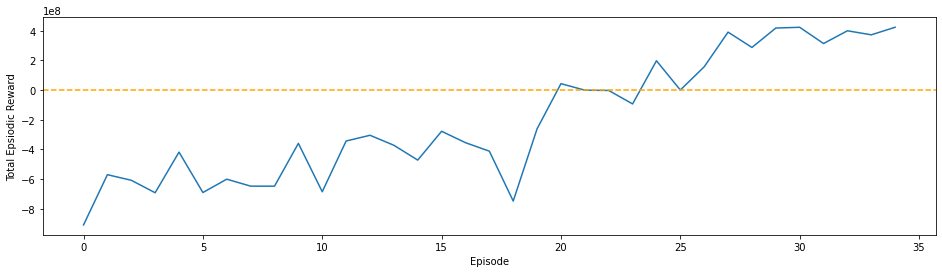

In [176]:
import matplotlib.pyplot as plt

# Plotting graph
# Episodes versus Avg. Rewards
plt.figure(figsize=(16,4));
plt.plot(sum_reward_hist);
plt.axhline( 0, ls='--', color='orange' )
plt.xlabel("Episode")
plt.ylabel("Total Epsiodic Reward")
plt.savefig('35epochs_episodes_vs_avgRewards.png', bbox_inches='tight')
plt.show()

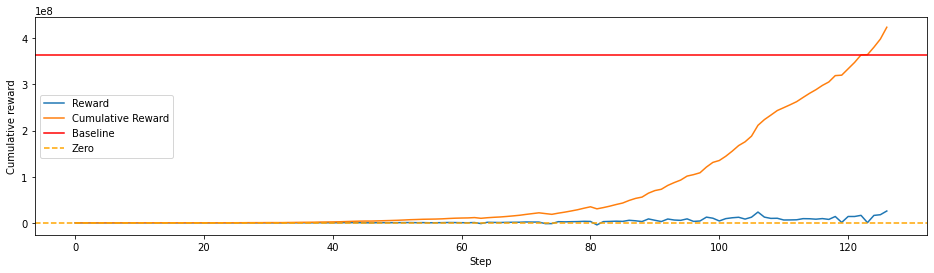

In [185]:
import matplotlib.pyplot as plt

# Plotting graph
# Step versus Cum. Rewards
plt.figure(figsize=(16,4));
plt.plot( env_train.reward_hist, label='Reward' );
plt.plot( np.cumsum(env_train.reward_hist), label='Cumulative Reward' );
plt.axhline( benchmark_train, label='Baseline', color='red' )
plt.axhline( 0, label='Zero', ls='--', color='orange' )
plt.xlabel("Step")
plt.ylabel("Cumulative reward")
plt.legend()
plt.savefig('35epochs_steps_vs_cumRewards.png', bbox_inches='tight')
plt.show()

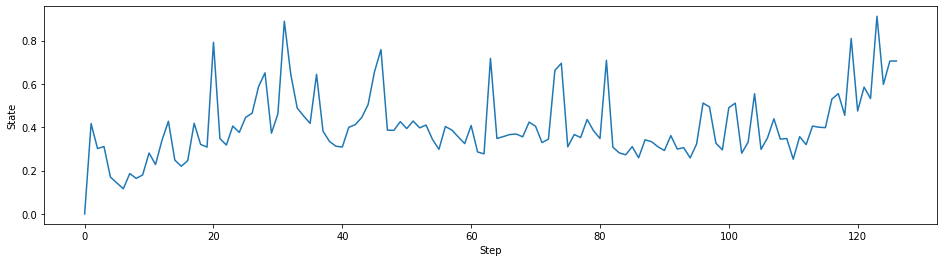

In [186]:
import matplotlib.pyplot as plt

# Plotting graph
# Steps versus State
plt.figure(figsize=(16,4));
plt.plot(env_train.state_hist);
plt.xlabel("Step")
plt.ylabel("State")
plt.savefig('35epochs_steps_vs_states.png', bbox_inches='tight')
plt.show()

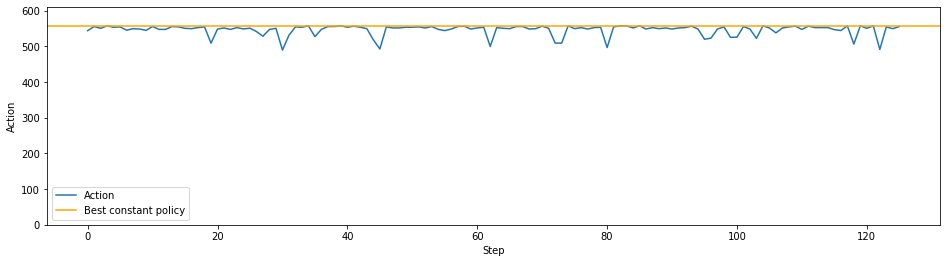

In [179]:
import matplotlib.pyplot as plt

# Plotting graph
# Steps versus Actons
plt.figure(figsize=(16,4));
plt.plot(env_train.action_hist[1:], label='Action');
plt.axhline(558, label='Best constant policy', color='orange')
plt.gca().set_ylim([0, 609])
plt.xlabel("Step")
plt.ylabel("Action")
plt.legend()
plt.savefig('35epochs_steps_vs_actions.png', bbox_inches='tight')
plt.show()

In [181]:
sum(env_train.reward_hist)

# -1499517018.2941222
# -1135815693.5728233
#  -663798560.9239142  - buffer 1000 batch 128
#  -565871890.5427336
#  -439308004.0259305  - v1
#  -386485924.8300973
#  -367064192.41714287 - v3
#  -279122913.44807124 - buffer 100 batch 32 - медленно
#   418698090.9763015

424077019.0871624

<h3>Смотрим на тест</h3>

In [182]:
for ep in range(1):
    print('---> Episode {} starts'.format(ep+1))

    ep_reward_hist = []
    # reset environment
    prev_state, reward, done, _ = env_test.reset(minYear=2018, minMonth=1)
    
    while True:
        # Predict loop

        # 1 - convert
        prev_state_arr = transformer.transform(prev_state)
        # 2 - tensor
        tf_prev_state = tf.convert_to_tensor(prev_state_arr)
        # 3 - get policy
        action = int( policy(tf_prev_state, train=False)[0] * max_score )
        # 4 - Make a step. Recieve state and reward from environment
        state, reward, done, _ = env_test.step( action  )
        # 5 - save interation reward stats
        ep_reward_hist.append(reward) 
        # 6.1 - End this episode when `done` is True
        if done:
            break
        # 6.2 - otherwise, move forward in time
        prev_state = state
    
    #################################################
    ############ print debug information ############
    #################################################
    
    print("---> Episode {} is over".format(ep+1))

---> Episode 1 starts
making step: 2018.1
making step: 2018.2
making step: 2018.3
making step: 2018.4
making step: 2018.5
---> Episode 1 is over


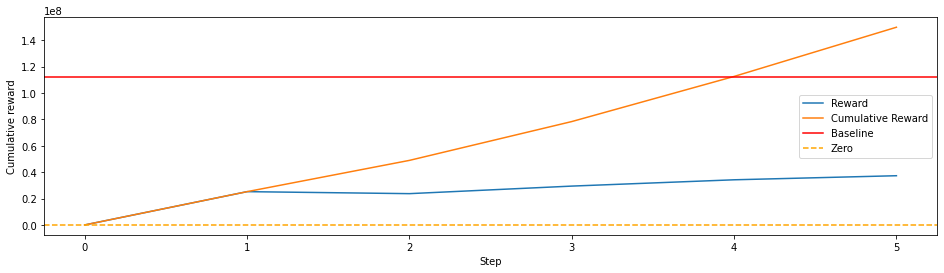

In [187]:
import matplotlib.pyplot as plt

# Plotting graph
# Step versus Cum. Rewards
plt.figure(figsize=(16,4));
plt.plot( env_test.reward_hist, label='Reward' );
plt.plot( np.cumsum(env_test.reward_hist), label='Cumulative Reward' );
plt.axhline( benchmark_test, label='Baseline', color='red' )
plt.axhline( 0, label='Zero', ls='--', color='orange' )
plt.xlabel("Step")
plt.ylabel("Cumulative reward")
plt.legend()
plt.savefig('test_steps_vs_cumRewards.png', bbox_inches='tight')
plt.show()

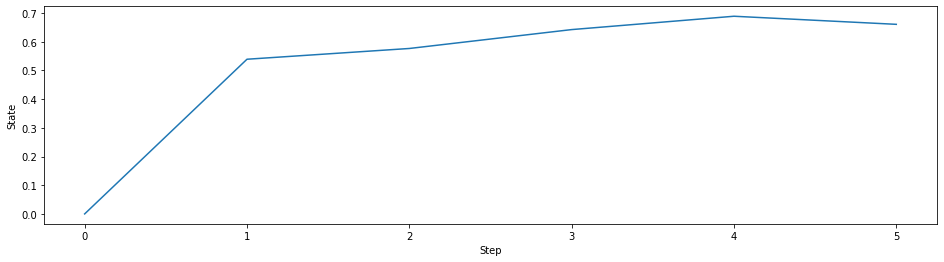

In [188]:
import matplotlib.pyplot as plt

# Plotting graph
# Steps versus State
plt.figure(figsize=(16,4));
plt.plot(env_test.state_hist);
plt.xlabel("Step")
plt.ylabel("State")
plt.savefig('test_steps_vs_states.png', bbox_inches='tight')
plt.show()

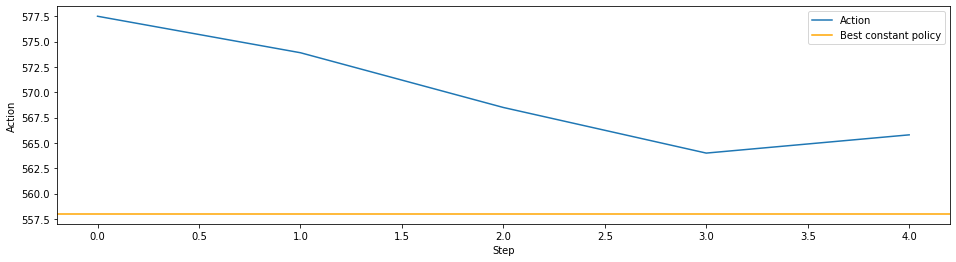

In [190]:
import matplotlib.pyplot as plt

# Plotting graph
# Steps versus Actons
plt.figure(figsize=(16,4));
plt.plot(env_test.action_hist[1:], label='Action');
plt.axhline(558, label='Best constant policy', color='orange')
plt.xlabel("Step")
plt.ylabel("Action")
plt.legend()
plt.savefig('test_steps_vs_actions.png', bbox_inches='tight')
plt.show()

In [191]:
print(f'''
На test:
    model\t{sum(env_train.reward_hist)}
    baseline\t{benchmark_test}
    ---
    diff\t{sum(env_train.reward_hist) - benchmark_test}
''')


На test:
    model	424077019.0871624
    baseline	112058233.81855965
    ---
    diff	312018785.2686027

